In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play the audio files
from IPython.display import Audio

# Importing TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en")

Skipping, found downloaded files in ".\speech-emotion-recognition-en" (use force=True to force download)


In [12]:
import patoolib
patoolib.extract_archive("/speech-emotion-recognition-en/speech-emotion-recognition-en.zip",outdir="/speech-emotion-recognition-en")

In [13]:
# Paths for datasets
Ravdess = "/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"
Crema = "/speech-emotion-recognition-en/Crema"
Tess = "/speech-emotion-recognition-en/Tess"
Savee = "/speech-emotion-recognition-en/Savee"

In [10]:
# Function to extract the emotion and path from datasets
def get_emotion_and_path(dataset_dir, emotion_extractor):
    file_emotion, file_path = [], []
    for dir_or_file in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, dir_or_file)):
            files = os.listdir(os.path.join(dataset_dir, dir_or_file))
            for file in files:
                file_emotion.append(emotion_extractor(file))
                file_path.append(os.path.join(dataset_dir, dir_or_file, file))
        else:
            file_emotion.append(emotion_extractor(dir_or_file))
            file_path.append(os.path.join(dataset_dir, dir_or_file))
    return pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

In [4]:
# Emotion extractor functions for each dataset
def ravdess_emotion_extractor(filename):
    return {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}[int(filename.split('-')[2])]

def crema_emotion_extractor(filename):
    part = filename.split('_')[2]
    return {'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'}.get(part, 'Unknown')

def tess_emotion_extractor(filename):
    part = filename.split('_')[2]
    return 'surprise' if part == 'ps' else part

def savee_emotion_extractor(filename):
    ele = filename.split('_')[1][:-6]
    return {'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprise'}[ele]

In [5]:
# Creating DataFrames for each dataset
Ravdess_df = get_emotion_and_path(Ravdess, ravdess_emotion_extractor)
Crema_df = get_emotion_and_path(Crema, crema_emotion_extractor)
Tess_df = get_emotion_and_path(Tess, tess_emotion_extractor)
Savee_df = get_emotion_and_path(Savee, savee_emotion_extractor)

In [6]:
# Combining all datasets
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
data_path.to_csv("data_path.csv", index=False)

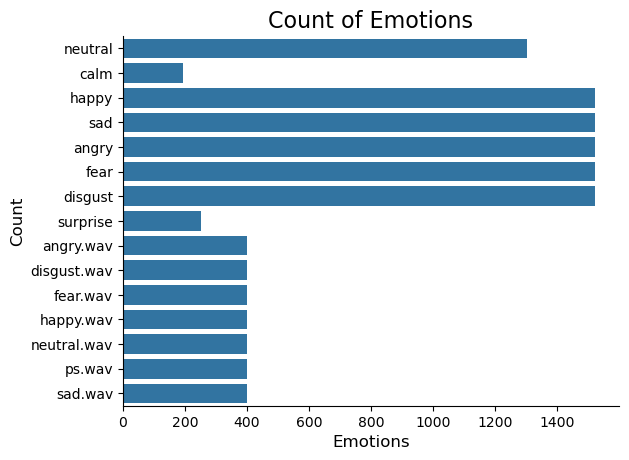

In [7]:
# Plotting emotion counts
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
# Function to create waveplot and spectrogram
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

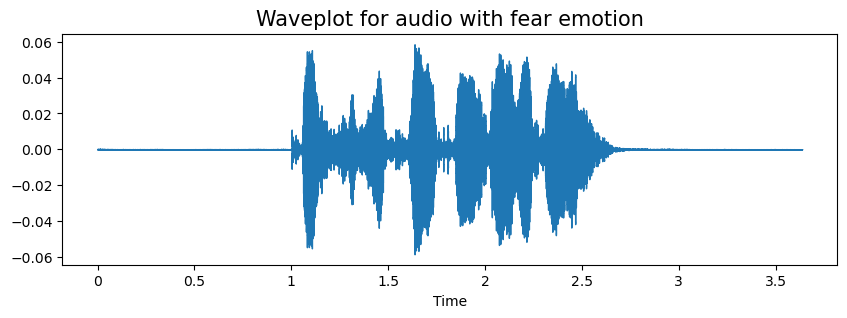

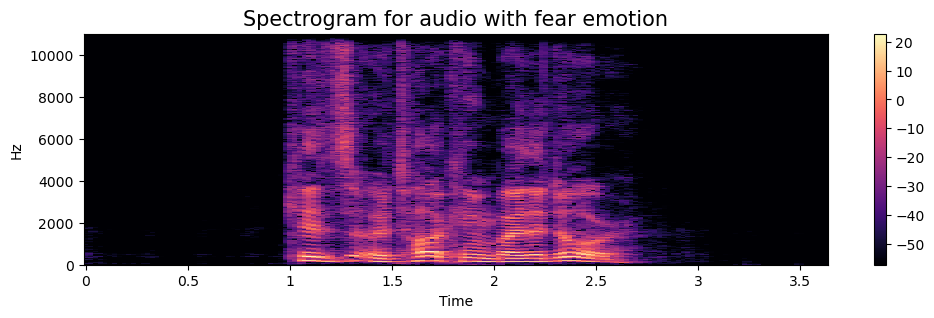

In [9]:
# Load an audio file and visualize
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [10]:
# Data augmentation functions
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    return data + noise_amp*np.random.normal(size=data.shape[0])

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, n_steps=pitch_factor, sr=sampling_rate)

In [11]:
# Feature extraction functions
def extract_features(data, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Feature
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # Mel-frequency cepstral coefficients (MFCC)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Energy (RMS)
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Feature extraction without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # Feature extraction with noise
    res2 = extract_features(noise(data), sample_rate)
    result = np.vstack((result, res2))
    
    # Feature extraction with stretching and pitching
    res3 = extract_features(pitch(stretch(data), sample_rate), sample_rate)
    result = np.vstack((result, res3))
    
    return result

In [12]:
def batch_features(data_paths, batch_size=32):
    X, Y = [], []
    for i in range(0, len(data_paths.Path), batch_size):
        batch_paths = data_paths.Path[i:i + batch_size]
        batch_emotions = data_paths.Emotions[i:i + batch_size]
        
        for path, emotion in zip(batch_paths, batch_emotions):
            feature = get_features(path)
            X.extend(feature)  # Use extend for list of arrays
            Y.extend([emotion] * len(feature))  # Append emotion for each feature
            
    return np.array(X), np.array(Y)

X, Y = batch_features(data_path, batch_size=32)

C:\Users\shawn\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [13]:
# Verifying the feature and label lengths
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [14]:
# Creating a DataFrame for features and saving
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750032,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116493e-06,8.190282e-06,0.000007,0.000005,4.245834e-07,neutral
1,0.327402,0.775293,0.842410,0.826040,0.809229,0.822561,0.744218,0.678498,0.717974,0.751508,...,9.223747e-05,9.061249e-05,9.542910e-05,8.662826e-05,9.107354e-05,9.550509e-05,0.000096,0.000093,8.975087e-05,neutral
2,0.188256,0.622125,0.699214,0.753343,0.721212,0.701727,0.682356,0.662828,0.686486,0.733960,...,8.579052e-07,9.576654e-07,7.733596e-07,5.233101e-07,3.592860e-07,9.261693e-07,0.000002,0.000001,7.753986e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984504e-06,7.034949e-06,6.654923e-06,6.979548e-06,1.214236e-05,9.640184e-06,0.000011,0.000006,4.254087e-07,neutral
4,0.311921,0.794966,0.820164,0.791680,0.784153,0.786405,0.689637,0.664732,0.718260,0.758183,...,7.415147e-05,7.907186e-05,7.158194e-05,7.667734e-05,8.776277e-05,7.949220e-05,0.000082,0.000073,6.811285e-05,neutral


In [15]:
# Splitting features and labels
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

# One-hot encoding the labels for multi-class classification
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [16]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Scaling the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Expanding dimensions to fit the Conv1D input requirement
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 15), (9122, 162, 1), (9122, 15))

In [20]:
# Building the CNN model
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(15, activation='softmax'))  # 15 output units for 15 emotion classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │             495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,519 (2.13 MB)

 Trainable params: 557,519 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Adding a learning rate reducer callback
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

# Training the model
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.2201 - loss: 2.2584 - val_accuracy: 0.4185 - val_loss: 1.5534 - learning_rate: 0.0010
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.3628 - loss: 1.6352 - val_accuracy: 0.4497 - val_loss: 1.3891 - learning_rate: 0.0010
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.4242 - loss: 1.4601 - val_accuracy: 0.4837 - val_loss: 1.2861 - learning_rate: 0.0010
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.4614 - loss: 1.3543 - val_accuracy: 0.4765 - val_loss: 1.2991 - learning_rate: 0.0010
Epoch 5/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.4792 - loss: 1.3168 - val_accuracy: 0.5117 - val_loss: 1.1980 - learning_rate: 0.0010
Epoch 6/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.4979 - loss: 1.2564 - val_accuracy: 0.5228 - val_loss: 1.1800 - learning_rate: 0.0010
Epoch 7/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.4997 - l

In [22]:
# Evaluating the model on test data
print("Accuracy of our model on test data:", model.evaluate(x_test, y_test)[1] * 100, "%")

286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6047 - loss: 1.0345
Accuracy of our model on test data: 60.22801995277405 %


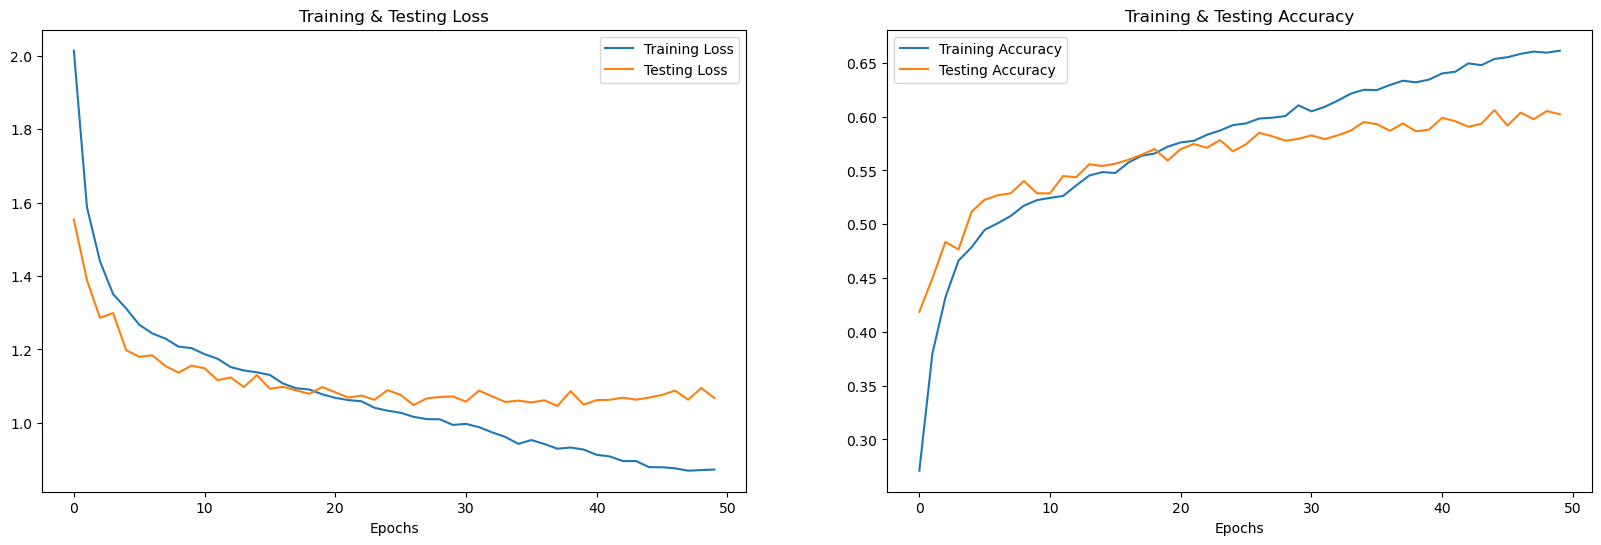

In [24]:
# Plotting training & testing loss and accuracy
epochs = range(50)
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Training & Testing Loss
ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Training & Testing Accuracy
ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

In [25]:
# Predicting on test data
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [26]:
# Creating a DataFrame for predictions and actual labels
df = pd.DataFrame({'Predicted Labels': y_pred.flatten(), 'Actual Labels': y_test.flatten()})
df.head(10)

,Predicted Labels,Actual Labels
0,sad,disgust
1,disgust.wav,disgust.wav
2,angry.wav,angry.wav
3,disgust,disgust
4,fear,fear
5,sad,fear
6,fear,happy
7,happy.wav,happy.wav
8,disgust,sad
9,neutral,sad


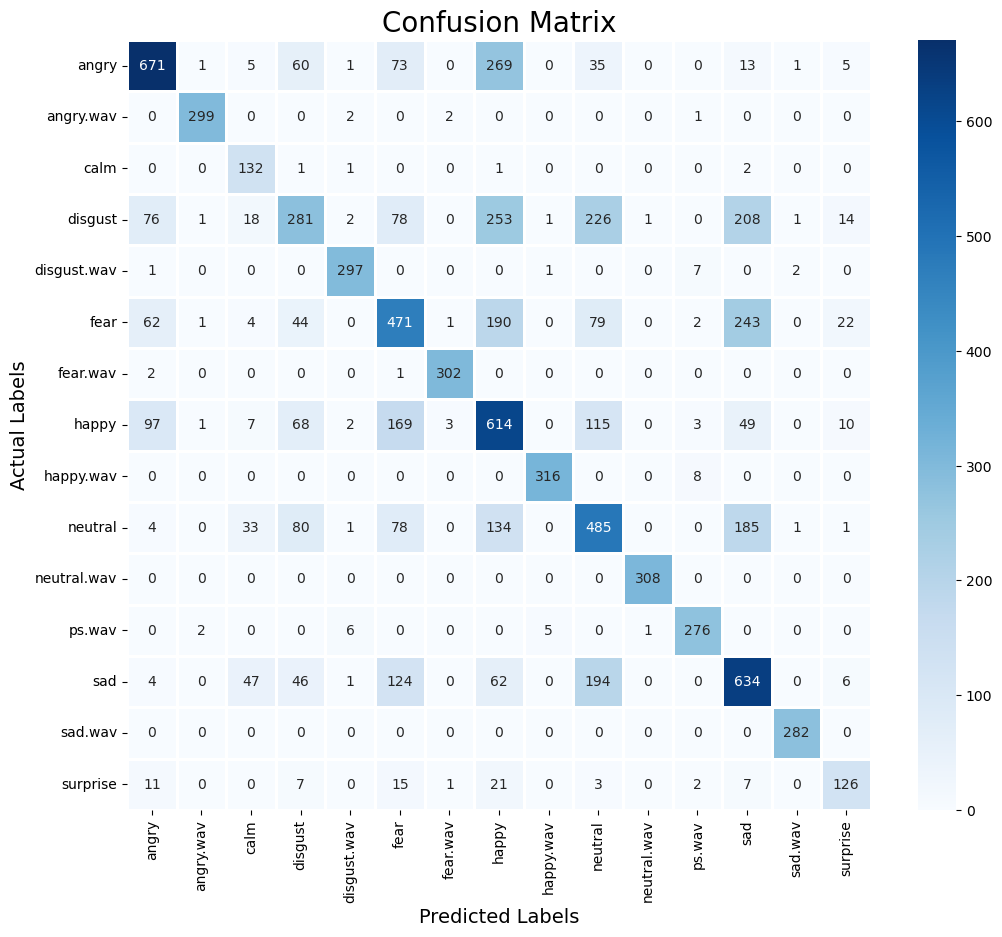

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])
sns.heatmap(cm_df, annot=True, fmt='', cmap='Blues', linewidths=1, linecolor='white')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [28]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.59      0.65      1134
   angry.wav       0.98      0.98      0.98       304
        calm       0.54      0.96      0.69       137
     disgust       0.48      0.24      0.32      1160
 disgust.wav       0.95      0.96      0.96       308
        fear       0.47      0.42      0.44      1119
    fear.wav       0.98      0.99      0.98       305
       happy       0.40      0.54      0.46      1138
   happy.wav       0.98      0.98      0.98       324
     neutral       0.43      0.48      0.45      1002
 neutral.wav       0.99      1.00      1.00       308
      ps.wav       0.92      0.95      0.94       290
         sad       0.47      0.57      0.52      1118
     sad.wav       0.98      1.00      0.99       282
    surprise       0.68      0.65      0.67       193

    accuracy                           0.60      9122
   macro avg       0.73      0.76      0.73      9122
weighted avg       0.61   